<h3>Using ResNET-50 for binary classification of images as real/fake</h3>


PARAMETERS:
1. batchsize = 30<br>
2. learningrate = 0.00001<br>
3. Optimizer = SGD (Stochastic Gradient Descent)<br>
4. momentum = 0.9<br>
5. Loss Function = Cross Entropy Loss<br>
6. Resized Resolution = 256 x 256<br>
7. epochs = 150<br>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

<h3>Read the image data from available dataset</h3>

In [2]:
# Path Definition
PATH = os.getcwd()
PATH = os.path.join(PATH, "biggan")
data_dir = PATH

# Batch Size
batch_size = 30

# Image Size
img_size = (256, 256)

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    validation_split=0.2,  # Split the data into training and validation sets (adjust as needed)
    subset="training",     # Use "training" for the training set
    seed=1337               # Optional: Set seed for reproducibility
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    validation_split=0.2,
    subset="validation",   # Use "validation" for the validation set
    seed=1337
)

Found 4000 files belonging to 2 classes.
Using 3200 files for training.
Found 4000 files belonging to 2 classes.
Using 800 files for validation.


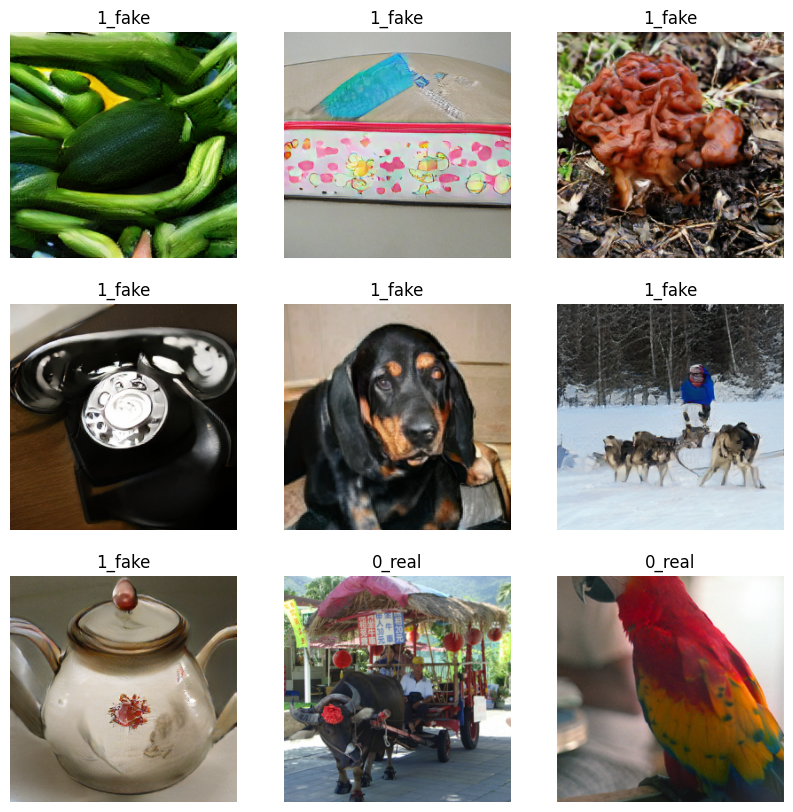

In [4]:
# Visualize 9 random images
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

<h3>Since there is no test dataset, We create one here</h3>

In [5]:
# Using 20% of the validation dataset as test dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print('Total number of batches: %d' % val_batches)
print('\nNumber of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Total number of batches: 27

Number of validation batches: 22
Number of test batches: 5


<h3>To improve runtime performance we prefetch data for next batch beforehand.</h3>

This is done by setting a buffer. AUTOTUNE does this automatically according the system resources

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

<h3>Since we are not working with large dataset we perform Data Augmentation </h3>

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

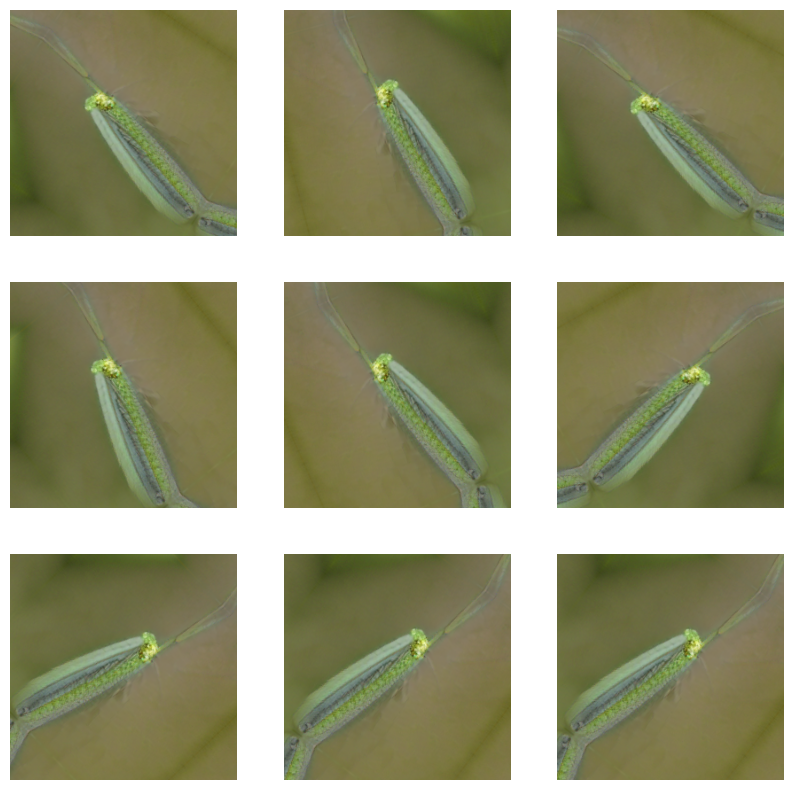

In [9]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

<h3>ResNET expects values of pixels in range [0,1]</h3>

In [10]:
preprocess_input = tf.keras.applications.resnet50.preprocess_input # Called later to preprocess
rescale = tf.keras.layers.Rescaling(1./255.0) # Called later to rescale

<h3>Now we bring in the pretrained ResNet50 Model</h3>

In [11]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                            include_top=False,
                                            weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print("Shape of the Feature Map from ResNET50:",feature_batch.shape)

Shape of the Feature Map from ResNET50: (30, 8, 8, 2048)


<h3>Now we freeze the top layers of ResNET50</h3>

In [13]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv3_block2_1_relu (Activ  (None, 32, 32, 128)          0         ['conv3_block2_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block2_2_conv (Conv2  (None, 32, 32, 128)          147584    ['conv3_block2_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_2_bn (BatchNo  (None, 32, 32, 128)          512       ['conv3_block2_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_blo

<h3>Now we add our own classification layers</h3>

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Average Pool to reduce size of input
feature_batch_average = global_average_layer(feature_batch)
print("Shape of reduced feature map:",feature_batch_average.shape)

prediction_layer = tf.keras.layers.Dense(units=1) # FCNN layer for classification
prediction_batch = prediction_layer(feature_batch_average)
print("Shape of output of prediction layer:",prediction_batch.shape)

Shape of reduced feature map: (30, 2048)
Shape of output of prediction layer: (30, 1)


In [15]:
# Build a compiled Model

inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()
print("Number of types of variables to learn:",len(model.trainable_variables),"(Weights and Biases)")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 256, 256, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

<h3>Compile the Model</h3>

In [16]:
learningrate = 0.00001
momentum = 0.9
epochs = 10
# Optimizer = SGD (Stochastic Gradient Descent)
# Loss Function = Cross Entropy Loss

In [17]:
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learningrate, momentum=momentum),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

<h3>Fit the Model</h3>

In [18]:
# Test Run
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

22/22 [==============================] - 156s 7s/step - loss: 0.9376 - accuracy: 0.4754
initial loss: 0.94
initial accuracy: 0.48


In [71]:
history = model.fit(train_dataset,
                    epochs=epochs,
                    validation_data=validation_dataset)

Epoch 1/10


107/107 [==============================] - 913s 8s/step - loss: 0.7827 - accuracy: 0.5006 - val_loss: 0.7373 - val_accuracy: 0.4831
Epoch 2/10
107/107 [==============================] - 780s 7s/step - loss: 0.7848 - accuracy: 0.5006 - val_loss: 0.7309 - val_accuracy: 0.5031
Epoch 3/10
107/107 [==============================] - 747s 7s/step - loss: 0.7634 - accuracy: 0.5006 - val_loss: 0.7319 - val_accuracy: 0.4892
Epoch 4/10
107/107 [==============================] - 839s 8s/step - loss: 0.7659 - accuracy: 0.5006 - val_loss: 0.7270 - val_accuracy: 0.4892
Epoch 5/10
 79/107 [=====================>........] - ETA: 3:22 - loss: 0.7588 - accuracy: 0.4979

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()